# Demonstration Script to Generate Stereo Data

Workflow:
1. Get all shapenet ids from 'data/objects'
2. Load occupany values from 'data/occupancy'
3. For each mesh
    - Render left image
    - right image
    - Return pose
4. Save images, poses, and occupancy to 'data/stereo_training_data'

In [1]:
import os
import os.path as osp
import matplotlib.pyplot as plt 

import numpy as np
import trimesh 
import pyrender
import doctest
import pickle
import os.path as osp
from scipy.spatial.transform import Rotation as R

from typing import List
import tqdm

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

## Get paths to everything

In [20]:
# -- Load Objects -- #
data_dir = '../data/'
objects_to_dir = {
    'mug': 'mug_centered_obj',
    'bowl': 'bowl_centered_obj',
    'bottle': 'bottle_centered_obj'
}
mug_data_path = osp.join(data_dir, 'objects', objects_to_dir['mug']) 
bowl_data_path = osp.join(data_dir, 'objects', objects_to_dir['bowl']) 
bottle_data_path = osp.join(data_dir, 'objects', objects_to_dir['bottle']) 

mug_shapenet_ids = os.listdir(mug_data_path)
bowl_shapenet_ids = os.listdir(bowl_data_path)
bottle_shapenet_ids = os.listdir(bottle_data_path)

# -- Load Occupancy -- #
mug_occ_path = osp.join(data_dir, 'occupancy', 'occ_shapenet_mug.p')
bowl_occ_path = osp.join(data_dir, 'occupancy', 'occ_shapenet_bowl.p')
bottle_occ_path = osp.join(data_dir, 'occupancy', 'occ_shapenet_bottle.p')

# -- Save dir -- #
mug_stereo_path = osp.join(data_dir, 'stereo_training_data', 'mug')
bowl_stereo_path = osp.join(data_dir, 'stereo_training_data', 'bowl')
bottle_stereo_path = osp.join(data_dir, 'stereo_training_data', 'bottle')

In [3]:
print(mug_shapenet_ids)
print(bowl_shapenet_ids)
print(bottle_shapenet_ids)

print(mug_data_path)
print(bowl_data_path)
print(bottle_data_path)

['ca198dc3f7dc0cacec6338171298c66b', '8f550770386a6cf82f23d8349a133d2b', '2d10421716b16580e45ef4135c266a12', '5c7c4cb503a757147dbda56eabff0c47', '8b1dca1414ba88cb91986c63a4d7a99a', 'b4ae56d6638d5338de671f28c83d2dcb', '3d1754b7cb46c0ce5c8081810641ef6', '962883677a586bd84a60c1a189046dd1', 'c0c130c04edabc657c2b66248f91b3d8', 'b88bcf33f25c6cb15b4f129f868dedb', 'a8f7a0edd3edc3299e54b4084dc33544', 'dcec634f18e12427c2c72e575af174cd', '6dd59cc1130a426571215a0b56898e5e', '71995893d717598c9de7b195ccfa970', 'daee5cf285b8d210eeb8d422649e5f2b', 'e6dedae946ff5265a95fb60c110b25aa', 'b18bf84bcd457ffbc2868ebdda32b945', '128ecbc10df5b05d96eaf1340564a4de', 'a637500654ca8d16c97cfc3e8a6b1d16', 'e9499e4a9f632725d6e865157050a80e', '6faf1f04bde838e477f883dde7397db2', '5d72df6bc7e93e6dd0cd466c08863ebd', '44f9c4e1ea3532b8d7b20fded0142d7a', '9d8c711750a73b06ad1d789f3b2120d0', '2852b888abae54b0e3523e99fd841f4', 'cf777e14ca2c7a19b4aad3cc5ce7ee8', 'e9bd4ee553eb35c1d5ccc40b510e4bd', '92d6394732e6058d4bcbafcc905a9b98

## Define render helpers

In [4]:
def make_rotation_matrix(axis: str, theta: float):
    """
    Make rotation matrix about {axis} with angle {theta}

    Args:
        axis (str): {'x', 'y', 'z'}
        theta (float): angle in radians
    """

    s = np.sin(theta)
    c = np.cos(theta)

    if axis == 'x':
        r = [[1, 0, 0],
             [0, c, -s],
             [0, s, c]]

    elif axis == 'y':
        r = [[c, 0, s],
             [0, 1, 0],
             [-s, 0, c]]

    elif axis == 'z':
        r = [[c, -s, 0],
             [s, c, 0],
             [0, 0, 1]]

    else:
        raise ValueError('Unexpected axis')

    return r

In [5]:
def make_camera_pose(r, theta):
    """
    Make homologous camera pose matrix using r and theta according to 
    diagram above.

    Args:
        r (float): Radius of cameras from scene orgin, unit is meters.
        theta (float): Angle of camera from z axis, unit is radians.
    >>> np.array_equal(make_camera_pose(1, 0), \
    np.array([[ 1.,  0.,  0.,  0.], \
              [ 0.,  1.,  0.,  0.], \
              [ 0.,  0.,  1.,  1.], \
              [ 0.,  0.,  0.,  1.]]))

    True
    """
    l_z = r * np.cos(theta)
    l_x = r * np.sin(theta)
    rotation = make_rotation_matrix('y', theta)

    pose_mat = np.eye(4)
    pose_mat[:3, :3] = rotation
    pose_mat[:3, 3] = np.array([l_x, 0, l_z])

    return pose_mat


In [6]:
def render_mesh(mesh_fname, n_samples=1000, cam_r=1, cam_theta=np.pi/16):
    """
    Render mesh in random poses.

    Note: If getting a display error, try 
    `os.environ['PYOPENGL_PLATFORM'] = 'egl'`

    Args:
        mesh_fname (string): path to mesh file
        n_samples (int, optional): Number of random poses to sample. Defaults to 1000.

    Returns:
        Tuple(np.array, np.array, np.array): Left image, right image, object pose
    """
    # -- Load mesh -- #
    mesh = trimesh.load(mesh_fname)
    scene = pyrender.Scene()
    renderer = pyrender.OffscreenRenderer(224, 224)
    baseColorFactor = [210, 210, 210, 1]
    texture = pyrender.MetallicRoughnessMaterial('mug_material', baseColorFactor=baseColorFactor) 
    mesh_node = scene.add(pyrender.Mesh.from_trimesh(mesh, material=texture))

 
    # -- Define Cameras -- #
    l_cam_pose = make_camera_pose(cam_r, -cam_theta)
    r_cam_pose = make_camera_pose(cam_r, cam_theta)

    camera = pyrender.PerspectiveCamera(yfov = np.pi / 3.0, aspectRatio=1.0)
    l_cam_node = scene.add(camera, pose=l_cam_pose)
    r_cam_node = scene.add(camera, pose=r_cam_pose)

    # -- Define Lights -- #
    light = pyrender.SpotLight(color=np.ones(3), 
                               intensity=3.0, 
                               innerConeAngle=np.pi/16.0, 
                               outerConeAngle=np.pi/6.0)
    scene.add(light, pose=l_cam_pose)
    scene.add(light, pose=r_cam_pose)

    # -- Render -- #
    color_l_images = []
    color_r_images = []
    object_poses = []
    for i in range(n_samples):
        random_pose = np.eye(4)
        random_pose[:3, :3] = R.random().as_matrix()
        scene.set_pose(mesh_node, pose=random_pose)

        scene.main_camera_node = l_cam_node
        color_l, depth_l = renderer.render(scene)
        scene.main_camera_node = r_cam_node
        color_r, depth_r = renderer.render(scene)

        color_l_images.append(color_l)
        color_r_images.append(color_r)
        object_poses.append(random_pose)
    
    renderer.delete()
    return color_l_images, color_r_images, object_poses

In [18]:
def render_batch(data_path: str, shapenet_ids: List[str], save_dir: str, n_samples_per_ob=1000):
    print('hi')
    os.makedirs(save_dir, exist_ok=True)
    
    # images are 224 x 224 x 3
    # images should be 3 x 224 x 224 so we use einsum to switch dims
    shapenet_ids_wrapped = tqdm.tqdm(shapenet_ids)
    for shapenet_id in shapenet_ids_wrapped:
        mesh_fname = osp.join(data_path, shapenet_id, 'models/model_128_df.obj')
        try:
            l_images, r_images, poses = render_mesh(mesh_fname, n_samples=n_samples_per_ob)
        except ValueError as e:
            print(e)
            print('Error rendering mesh: ', shapenet_id)
            continue

        id_save_dir = osp.join(save_dir, shapenet_id)
        os.makedirs(id_save_dir, exist_ok=True)
        for i, data in enumerate(zip(l_images, r_images, poses)):
            l_image, r_image, pose = data

            l_image = np.einsum('ijk->kij', l_image)
            r_image = np.einsum('ijk->kij', r_image)

            # -- Make same datatype -- #
            l_image = l_image.astype(np.float32) / 255
            r_image = r_image.astype(np.float32) / 255
            pose = pose.astype(np.float32)
            
            save_fname = osp.join(id_save_dir, 'pose_' + str(i))
            # You must load the occupany with the dataloader
            np.savez(save_fname,
                l_image = l_image,
                r_image = r_image,
                pose = pose,
                # shapenet_id = shapenet_id,
            )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 5, 3)


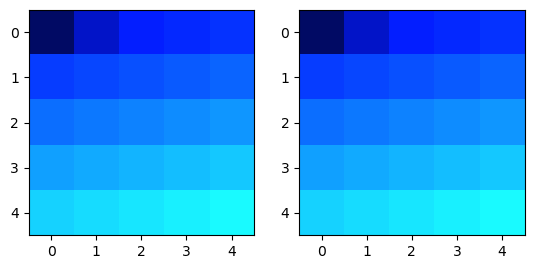

In [14]:
one_channel = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25]
])
two_channel = one_channel * 10
three_channel = one_channel * 100

color_im = np.stack([one_channel, two_channel, three_channel], axis=2)
reshaped_image = np.einsum('ijk->kij', color_im)
print(color_im.shape)
fig, ax = plt.subplots(1, 2)


reconstruct_reshape = np.stack([reshaped_image[0], reshaped_image[1], reshaped_image[2]], axis=2)
ax[0].imshow(color_im)
ax[1].imshow(reconstruct_reshape)

In [ ]:
render_batch(mug_data_path, mug_shapenet_ids, mug_stereo_path, n_samples_per_ob=10)

In [20]:
def plot_image_lists(l_images, r_images):
    """
    Plot list of images side by side.

    Args:
        l_images (list): List of left images
        r_images (list): List of right images
    """
    import matplotlib.pyplot as plt
    im_dim = 2
    fig, axs = plt.subplots(len(l_images), 2, figsize=(2 * im_dim, len(l_images) * im_dim))
    for i in range(len(l_images)):
        axs[i, 0].imshow(l_images[i])
        axs[i, 1].imshow(r_images[i])
    plt.show()

[[ 0.23482723  0.75977993 -0.60629252  0.        ]
 [-0.96198636  0.27111542 -0.03284311  0.        ]
 [ 0.13942171  0.5909576   0.79456322  0.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.4034903   0.50119023 -0.76550893  0.        ]
 [ 0.26594163 -0.73627954 -0.62222785  0.        ]
 [-0.87548308 -0.45464359  0.16379431  0.        ]
 [ 0.          0.          0.          1.        ]]


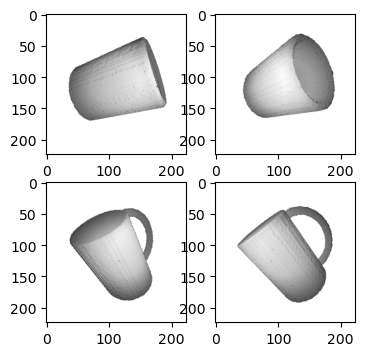

In [25]:
l_image_list = []
r_image_list = []

for i in range(337, 339):
    test_data = np.load(osp.join(mug_stereo_path, 'ca198dc3f7dc0cacec6338171298c66b', f'pose_{i}.npz'), allow_pickle=True)
    # test_data = np.load(osp.join(mug_stereo_path, '962883677a586bd84a60c1a189046dd1', f'pose_{i}.npz'), allow_pickle=True)
    l_image_list.append(np.einsum('ijk->jki', test_data['l_image']))
    r_image_list.append(np.einsum('ijk->jki', test_data['r_image']))
    print(test_data['pose'])
    # print(test_data['shapenet_id'])
plot_image_lists(l_image_list, r_image_list)

In [21]:
# -- Fix image that broke when np.savez was stopped :/ -- #
# render_batch(mug_data_path, ['962883677a586bd84a60c1a189046dd1'], mug_stereo_path, n_samples_per_ob=1000)
render_batch(bowl_data_path, ['8d75c3c065fa3c7055f46d55537192b6'], bowl_stereo_path, n_samples_per_ob=1000)

hi


  0%|          | 0/1 [00:00<?, ?it/s]

saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
save

100%|██████████| 1/1 [00:13<00:00, 13.42s/it]

saved
saved
saved
saved
saved
saved
saved
saved
saved
